# Bitcoin USD - Time Series Forecasting
# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [1]:
# Standard library imports
import os
import time
import warnings
import sys
import requests


# Third party imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import r2_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Local application imports
# Import other necessary libraries and modules here
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Span, Range1d
from bokeh.layouts import column
from bokeh.models.widgets import Button
from bokeh.models.callbacks import CustomJS
from bokeh.themes import Theme
from math import pi
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, WheelZoomTool
import pandas as pd


warnings.filterwarnings('ignore')


# Block 1 - CryptoData

In [2]:
# Block 1 - load data with CmC Scrapper
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.
    
    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.
        
    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        try:
            scraper = CmcScraper(self.crypto_symbol)
            return scraper.get_dataframe()
        except Exception as e:
            print(f'An error occurred while fetching data: {e}')
            return pd.DataFrame()  # Return an empty DataFrame when an error occurs

    def get_cryptocmd_data(self) -> pd.DataFrame:
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close', 'Market Cap']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)
        display_df['Volume'] = display_df['Volume'].apply(self._format_volume_value)
        return display_df

In [3]:
crypto = CryptoData("BTC")

data = crypto.get_cryptocmd_data()
display_data = crypto.get_display_data()
display_data
data.to_csv('dadada.csv')

# Block 2 - CryptoAnalytics

# -------------------------------------------------------------------------------------

In [4]:
# Block 2 - Crypto analytics
class CryptoAnalytics:
    """
    This class is responsible for performing analytics on cryptocurrency data.
    
    Input:
        df (pd.DataFrame): The DataFrame containing the cryptocurrency data.
        
    Methods:
        get_all_time_records: Returns the all-time high and low closing prices.
        get_yearly_analysis: Returns yearly high, low, average, and variation.
        get_monthly_analysis: Returns monthly high, low, average, and variation.
        get_weekly_analysis: Returns weekly high, low, average, and variation.
    """

    def __init__(self, crypto_data: CryptoData):
        self.df = crypto_data.get_cryptocmd_data()
    
    def format_and_round(self, number):
        return f'{number:,.2f}'

    def apply_custom_formatting(self, data):
        ordered_columns = [
            'Open_first', 'Close_last', 'variation_$_abs',
            'variation_%_rel', 'Close_min', 'Close_mean', 'Close_max'
        ]
        data = data[ordered_columns]
        return data

    def get_all_time_records(self):
        all_time_high = self.df['Close'].max()
        all_time_low = self.df['Close'].min()
        all_time_high_date = self.df['Close'].idxmax().strftime('%Y-%m-%d')
        all_time_low_date = self.df['Close'].idxmin().strftime('%Y-%m-%d')
        return all_time_high, all_time_low, all_time_high_date, all_time_low_date
    
    def get_yearly_analysis(self):
        yearly_data = self.df.resample('Y').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        yearly_data.columns = yearly_data.columns.map('_'.join).str.strip('_')
        yearly_data = self.calculate_variation(yearly_data)
        return self.apply_custom_formatting(yearly_data)

    def get_monthly_analysis(self):
        monthly_data = self.df.resample('M').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        monthly_data.columns = monthly_data.columns.map('_'.join).str.strip('_')
        monthly_data = self.calculate_variation(monthly_data)
        return self.apply_custom_formatting(monthly_data)

    def get_weekly_analysis(self):
        weekly_data = self.df.resample('W').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        weekly_data.columns = weekly_data.columns.map('_'.join).str.strip('_')
        weekly_data = self.calculate_variation(weekly_data)
        return self.apply_custom_formatting(weekly_data)

    def calculate_variation(self, data):
        data['variation_$_abs'] = data['Close_last'] - data['Open_first']
        data['variation_%_rel'] = ((data['Close_last'] - data['Open_first']) / data['Open_first']) * 100
        return data

    def display_all_analyses(self):
        all_time_high, all_time_low, all_time_high_date, all_time_low_date = self.get_all_time_records()
        print(f"All Time High: {self.format_and_round(all_time_high)} (Date: {all_time_high_date})")
        print(f"All Time Low: {self.format_and_round(all_time_low)} (Date: {all_time_low_date})")

        print("\nYearly Analysis:")
        display(self.get_yearly_analysis())

        print("\nMonthly Analysis:")
        display(self.get_monthly_analysis())

        print("\nWeekly Analysis:")
        display(self.get_weekly_analysis())


In [5]:
# Create an instance of CryptoAnalytics
analytics = CryptoAnalytics(crypto)

# Display all analyses
analytics.display_all_analyses()

All Time High: 67,566.83 (Date: 2021-11-08)
All Time Low: 68.43 (Date: 2013-07-05)

Yearly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-12-31,135.30,754.01,618.71,457.287509,68.43,257.474395,1151.17
2014-12-31,754.97,320.19,-434.78,-57.589043,310.74,527.236548,953.29
2015-12-31,320.43,430.57,110.14,34.372562,178.10,272.453397,465.32
2016-12-31,430.72,963.74,533.02,123.750929,364.33,568.492186,975.92
2017-12-31,963.66,14156.40,13192.74,1369.024345,777.76,4006.033616,19497.40
2018-12-31,14112.20,3742.70,-10369.50,-73.478976,3236.76,7572.298877,17527.00
2019-12-31,3746.71,7193.60,3446.89,91.997779,3399.47,7395.246630,13016.23
2020-12-31,7194.89,29001.72,21806.83,303.087747,4970.79,11116.377869,29001.72
2021-12-31,28994.01,46306.45,17312.44,59.710402,29374.15,47436.932247,67566.83



Monthly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-30,135.30,139.00,3.70,2.734664,134.21,139.250000,144.54
2013-05-31,139.00,129.00,-10.00,-7.194245,97.75,119.992581,133.48
2013-06-30,128.82,96.61,-32.21,-25.003881,94.65,107.761333,129.30
2013-07-31,97.51,106.09,8.58,8.799098,68.43,90.512258,107.99
2013-08-31,106.21,135.35,29.14,27.436211,102.80,113.905161,135.35
...,...,...,...,...,...,...,...
2023-02-28,23137.84,23147.35,9.51,0.041102,21651.18,23304.538214,24829.15
2023-03-31,23150.93,28478.48,5327.55,23.012250,20187.24,25116.900645,28478.48
2023-04-30,28473.33,29268.81,795.48,2.793772,27276.91,28851.102667,30485.70



Weekly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-28,135.30,134.21,-1.09,-0.805617,134.21,134.210000,134.21
2013-05-05,134.44,115.91,-18.53,-13.783100,97.75,118.842857,144.54
2013-05-12,115.98,115.00,-0.98,-0.844973,111.50,113.925714,117.20
2013-05-19,114.82,121.99,7.17,6.244557,111.50,118.708571,123.50
2013-05-26,122.50,133.48,10.98,8.963265,122.00,127.732857,133.48
...,...,...,...,...,...,...,...
2023-05-28,26749.89,28085.65,1335.76,4.993516,26334.82,26937.332857,28085.65
2023-06-04,28075.59,27119.07,-956.52,-3.406945,26819.97,27275.950000,27745.88
2023-06-11,27123.11,25940.17,-1182.94,-4.361373,25760.10,26303.555714,27238.78


# Block 3 - CryptoVisual

# -------------------------------------------------------------------------------------

In [6]:
# block 3 
class CryptoVisual:
    """
    This class is responsible for creating candlestick charts with a moving average line using Bokeh.
    
    Input:
        data (pd.DataFrame): DataFrame containing OHLC data with 'Date' as the index.
        
    Methods:
        create_candlestick_chart: Creates a candlestick chart with a moving average line using Bokeh.
        create_line_chart: Creates a line chart with a moving average line using Bokeh.
    """
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def create_candlestick_chart(self, time_period='last_month', ma_period=20):
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        inc = df.Close > df.Open
        dec = df.Open > df.Close

        # Create separate ColumnDataSources for positive and negative daily variations
        source_inc = ColumnDataSource(df[inc])
        source_dec = ColumnDataSource(df[dec])
        source_hover = ColumnDataSource(df)

        w = 12 * 60 * 60 * 1000  # half day in ms

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

        p = figure(x_axis_type="datetime", tools=TOOLS, width=950, title="Crypto Candlestick with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot positive daily variations (green)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_inc)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#39B86B", line_color="black", source=source_inc)

        # Plot negative daily variations (red)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_dec)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#F2583E", line_color="black", source=source_dec)
        
        # Enable scroll wheel zoom
        p.toolbar.active_scroll = p.select_one(WheelZoomTool)

        # Add hover tool
        hover = HoverTool(
            tooltips=[
                ("Date", "@index_col{%F}"),  # date hover label
                ("Open", "@{Open}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Close", "@{Close}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("High", "@{High}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Low", "@{Low}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("MA", "@{MA}{($ 0,0.00)}"),  # moving average hover label
            ],
            formatters={
                '@index_col': 'datetime',  # format date hover label as date
                '@Open': 'numeral',  # format numerical data
                '@Close': 'numeral',  # format numerical data
                '@High': 'numeral',  # format numerical data
                '@Low': 'numeral',  # format numerical data
                '@MA': 'numeral',
            },
            mode='vline'  # display a tooltip whenever the cursor is vertically in line with a glyph
        )
        p.add_tools(hover)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source_hover)

        show(p)  # open a browser

    def create_line_chart(self, time_period='last_month', ma_period=20):
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        source = ColumnDataSource(df)

        p = figure(x_axis_type="datetime", tools="pan,wheel_zoom,box_zoom,reset,save", width=950, title="Crypto Line Chart with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot line chart
        p.line('index_col', 'Close', color='black', legend_label='Close', source=source)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source)

        show(p)  # open a browser

    def _select_data(self, time_period):
        if time_period == 'last_month':
            last_month = self.data.index.max() - pd.DateOffset(months=1)
            df = self.data[self.data.index >= last_month]
        elif time_period == 'last_3_months':
            last_3_months = self.data.index.max() - pd.DateOffset(months=3)
            df = self.data[self.data.index >= last_3_months]
        elif time_period == 'last_6_months':
            last_6_months = self.data.index.max() - pd.DateOffset(months=6)
            df = self.data[self.data.index >= last_6_months]
        elif time_period == 'last_1_year':
            last_1_year = self.data.index.max() - pd.DateOffset(years=1)
            df = self.data[self.data.index >= last_1_year]
        elif time_period == 'last_3_years':
            last_3_years = self.data.index.max() - pd.DateOffset(years=3)
            df = self.data[self.data.index >= last_3_years]
        else:
            df = self.data
        
        return df

In [7]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create candlestick chart
crypto_visual.create_candlestick_chart(time_period='last_6_months', ma_period=20)


In [8]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create line chart
crypto_visual.create_line_chart(time_period='all', ma_period=20)

# Block 4 - TimeSeriesAnalysis

# -------------------------------------------------------------------------------------

In [9]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import matplotlib.pyplot as plt

class TimeSeriesAnalysis:
    def __init__(self, data):
        self.data = data

    def check_stationarity(self):
        result = adfuller(self.data)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[1] <= 0.05:
            print('The series is likely stationary.')
        else:
            print('The series is likely non-stationary.')

    def check_autocorrelation(self):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

        plot_acf(self.data, lags=50, alpha=0.05, ax=ax1)
        plt.title("ACF for Close Price", size=20)

        plot_pacf(self.data, lags=50, alpha=0.05, method='ols', ax=ax2)
        plt.title("PACF for Close Price -- Daily", size=20)

    def check_volatility(self):
        model = arch_model(self.data, vol='Garch', p=1, q=1)
        model_fit = model.fit()
        print(model_fit.summary())

In [10]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

ADF Statistic: -1.716141
p-value: 0.422816
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The series is likely non-stationary.
Iteration:      1,   Func. Count:      6,   Neg. LLF: 124596.0721616781
Iteration:      2,   Func. Count:     12,   Neg. LLF: 38973.256883528404
Iteration:      3,   Func. Count:     17,   Neg. LLF: 38973.152376350205
Iteration:      4,   Func. Count:     22,   Neg. LLF: 38972.63831473828
Iteration:      5,   Func. Count:     27,   Neg. LLF: 38970.15542423096
Iteration:      6,   Func. Count:     32,   Neg. LLF: 38958.79572550531
Iteration:      7,   Func. Count:     37,   Neg. LLF: 38932.4053164338
Iteration:      8,   Func. Count:     42,   Neg. LLF: 38819.68965090047
Iteration:      9,   Func. Count:     47,   Neg. LLF: 38301.78626819057
Iteration:     10,   Func. Count:     52,   Neg. LLF: 37181.24132121799
Iteration:     11,   Func. Count:     57,   Neg. LLF: 46268.082501965226
Iteration:     12,   Func. Count:     64,   Neg. LLF: 36947.90474554354


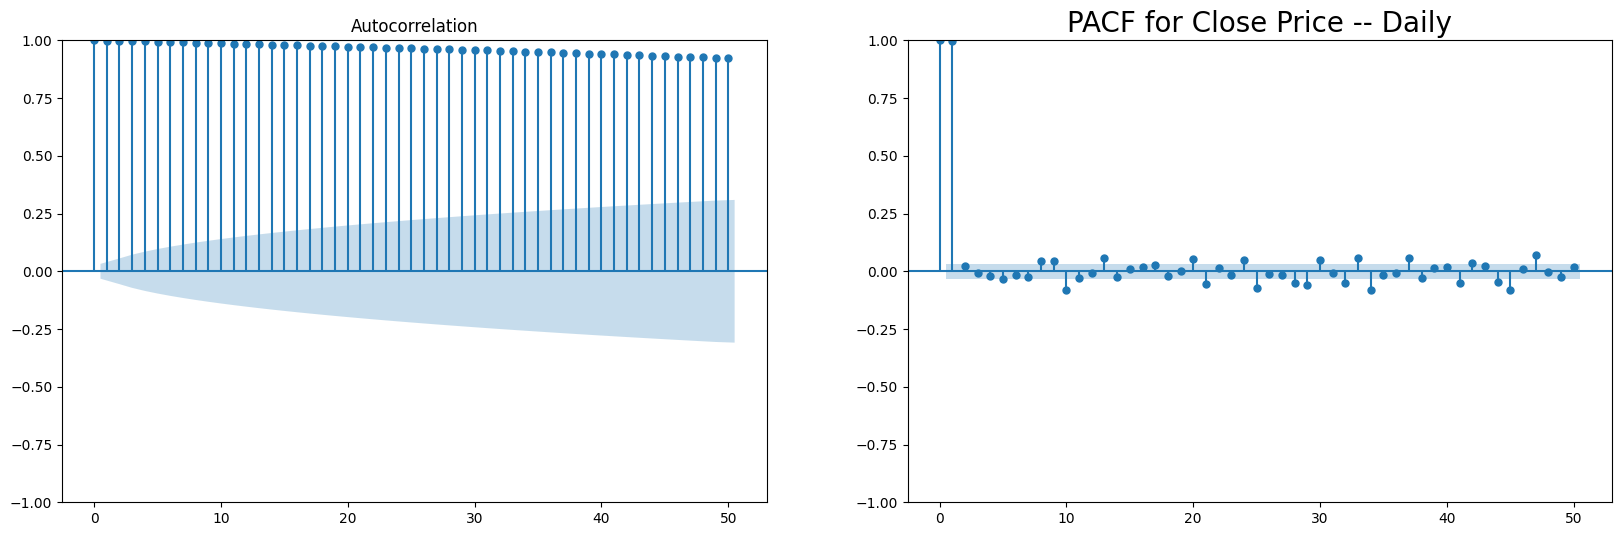

In [11]:
# Create an instance of the TimeSeriesAnalysis class
tsa = TimeSeriesAnalysis(data['Close'])
# Call the methods on the instance
tsa.check_stationarity()
tsa.check_volatility()
tsa.check_autocorrelation()

# Block 5 - DataPreprocessing

# -------------------------------------------------------------------------------------

In [12]:
class DataPreprocessing:
    
    def __init__(self, data, targets=[], columns_to_scale=[], random_state=None):
        self.data = data.sort_index(ascending=True)
        self.targets = targets
        self.columns_to_scale = columns_to_scale
        self.random_state = random_state
        self.data_scaled = None  # Initialize the data_scaled attribute
        
    def missing_values_table(self):
        mis_val = self.data.isnull().sum()
        mis_val_percent = 100 * mis_val / len(self.data)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'Missing Values', 1: '% of Total Values'}
        )
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:, 1] != 0
        ].sort_values('% of Total Values', ascending=False).round(1)

        print(
            f"Your selected dataframe has {self.data.shape[1]} columns.\n"
            f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values."
        )

        return mis_val_table_ren_columns
    
    def normalize_and_scale(self):
        # Create a copy of the original DataFrame
        data_normalized = self.data.copy()

        # Instantiate the StandardScaler
        self.scaler = StandardScaler()

        # Instantiate a separate StandardScaler for the 'Close' prices
        self.close_scaler = StandardScaler()

        # Apply StandardScaler to the specified columns
        data_normalized[self.columns_to_scale] = self.scaler.fit_transform(data_normalized[self.columns_to_scale])

        # Fit the close_scaler on the 'Close' prices
        self.close_scaler.fit(data_normalized[['Close']])

        self.data_scaled = data_normalized
        return self.data_scaled


    def split_data(self, splitter):
        # Ensure that data_normalized has been calculated
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")
        
        # Calculate the index position to split the data
        split_index = int(len(self.data_scaled) * (1 - splitter))

        # Split the data into train and test sets
        data_train = self.data_scaled.iloc[:split_index]
        data_test = self.data_scaled.iloc[split_index:]

        X_train = data_train.loc[:, data_train.columns != 'Close']
        y_train = data_train.loc[:, 'Close']

        X_test = data_test.loc[:, data_test.columns != 'Close']
        y_test = data_test.loc[:, 'Close']

        # Convert to NumPy array
        y_train= y_train.to_numpy()
        y_test= y_test.to_numpy()
        X_train= X_train.to_numpy()
        X_test= X_test.to_numpy()

        # Reshape to 3D [samples, timesteps, features]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        return X_train, y_train, X_test, y_test

    def visualize_split(self, train_close, test_close):
        # Restore target values before normalization
        y_train_restored = self.data['Close'][:len(y_train)]
        y_test_restored = self.data['Close'][len(y_train):]

        train_dates = self.data.index[:len(train_close)]
        test_dates = self.data.index[-len(test_close):]

        # Set up Bokeh figure
        p = figure(width=950, height=500, x_axis_type="datetime", title="Training and Testing Data")

        # Add gridlines to the plot
        p.xgrid.grid_line_color = "gray"
        p.ygrid.grid_line_color = "gray"
        p.xgrid.grid_line_alpha = 0.3
        p.ygrid.grid_line_alpha = 0.3

        # Training Data Line
        p.line(train_dates, y_train_restored, color='blue', legend_label='Training Data', line_width=2)

        # Testing Data Line
        p.line(test_dates, y_test_restored, color='orange', legend_label='Testing Data', line_width=2)

        # Add hover tool
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Value", "$@y{0,0.00}")],
                  formatters={"@x": "datetime"})

        p.add_tools(hover)
        p.toolbar.logo = None
        # Show the dynamic line chart
        show(p)

In [13]:
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
preprocessor = DataPreprocessing(data, columns_to_scale=columns_to_scale)
data_normalized = preprocessor.normalize_and_scale()

In [14]:
# Split the data into train and test sets
X_train, y_train, X_test, y_test = preprocessor.split_data(splitter=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2965, 1, 5) (2965,) (742, 1, 5) (742,)


In [15]:
preprocessor.visualize_split(y_train, y_test)

# -------------------------------------------------------------------------------------

In [16]:
class LSTM_Models:
    def __init__(self, X_train, y_train, X_test, y_test, model):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model

    def train_model(self, epochs=100, batch_size=50):
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(self.X_test, self.y_test), shuffle=False)
        
    def make_predictions(self, close_scaler):
        # Make predictions on the normalized data
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)
        # Invert predictions to get them on the same scale as the original data
        train_predict = close_scaler.inverse_transform(train_predict)
        y_train_rescaled = close_scaler.inverse_transform([self.y_train])
        test_predict = close_scaler.inverse_transform(test_predict)
        y_test_rescaled = close_scaler.inverse_transform([self.y_test])
        # Create a DataFrame to compare actual vs predicted values for the training data
        train_comparison_df = pd.DataFrame({
            'Actual': y_train_rescaled[0],
            'Predict': train_predict[:,0]
        })
        # Create a DataFrame to compare actual vs predicted values for the testing data
        test_comparison_df = pd.DataFrame({
            'Actual': y_test_rescaled[0],
            'Predict': test_predict[:,0]
        })

        return train_comparison_df, test_comparison_df
    
    def plot_history(self):
        plt.figure(figsize=(14, 7))
        # Plot the loss
        plt.plot(self.history.history['loss'], label='Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        # Add title and labels
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        # Show the plot
        plt.show()
        
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    
    def evaluate_model(self, train_comparison_df, test_comparison_df):
        # Calculate metrics for the training data
        train_rmse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'], squared=False)
        train_mae = mean_absolute_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_mse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_r2 = r2_score(train_comparison_df['Actual'], train_comparison_df['Predict'])
        # Calculate metrics for the testing data
        test_rmse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'], squared=False)
        test_mae = mean_absolute_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_mse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_r2 = r2_score(test_comparison_df['Actual'], test_comparison_df['Predict'])
        # Create a DataFrame to hold the results
        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })
        
        return results_df

    def plot_predictions(self, train_comparison_df, test_comparison_df):
        plt.figure(figsize=(14, 7))
        # Plot the actual and predicted values for the training data
        plt.subplot(1, 2, 1)
        plt.plot(train_comparison_df['Actual'], label='Actual')
        plt.plot(train_comparison_df['Predict'], label='Predict')
        plt.title('Training Data: Actual vs Predicted')
        plt.legend()
        # Plot the actual and predicted values for the testing data
        plt.subplot(1, 2, 2)
        plt.plot(test_comparison_df['Actual'], label='Actual')
        plt.plot(test_comparison_df['Predict'], label='Predict')
        plt.title('Testing Data: Actual vs Predicted')
        plt.legend()
        # Show the plot
        plt.show()
model1 = Sequential()
model1.add(LSTM(120, activation="sigmoid", input_shape=(1, 5)))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

# Define model 3
model2 = Sequential()
model2.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(1, 5)))
model2.add(Dropout(0.2))
model2.add(LSTM(128, activation='tanh', return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(256, activation='tanh', return_sequences=True))
model2.add(Dropout(0.4))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

# Define model 3
model3 = Sequential()
model3.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(1, 5)))
model3.add(Dropout(0.2))
model3.add(LSTM(128, activation='tanh', return_sequences=True))
model3.add(Dropout(0.3))
model3.add(LSTM(256, activation='tanh', return_sequences=True))
model3.add(Dropout(0.4))
model3.add(LSTM(256, activation='tanh', return_sequences=True))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')

# Define model 4
model4 = Sequential()
model4.add(TimeDistributed(Conv1D(64, 3, activation='sigmoid'), input_shape=(None, 5, 1)))
model4.add(TimeDistributed(MaxPooling1D(2)))
model4.add(TimeDistributed(Flatten()))
model4.add(TimeDistributed(Dense(64)))
model4.add(LSTM(128, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
stop

NameError: name 'stop' is not defined

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# Initialize and train the LSTM model 1
lstm_1 = LSTM_Models(X_train, y_train, X_test, y_test, model1)
lstm_1.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_1.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 2
lstm_2 = LSTM_Models(X_train, y_train, X_test, y_test, model2)
lstm_2.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_1.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 3
lstm_3 = LSTM_Models(X_train, y_train, X_test, y_test, model3)
lstm_3.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_3.make_predictions(preprocessor.close_scaler)

In [ ]:
lstm_1.plot_history()
lstm_2.plot_history()
lstm_3.plot_history()

In [ ]:
lstm_1.plot_predictions(train_comparison_df, test_comparison_df)
lstm_2.plot_predictions(train_comparison_df, test_comparison_df)
lstm_3.plot_predictions(train_comparison_df, test_comparison_df)

In [ ]:
results_df1 = lstm_1.evaluate_model(train_comparison_df, test_comparison_df)
results_df2 = lstm_2.evaluate_model(train_comparison_df, test_comparison_df)
results_df3 = lstm_3.evaluate_model(train_comparison_df, test_comparison_df)
#results_df4 = lstm_4.evaluate_model(train_comparison_df, test_comparison_df)

print(results_df1, results_df2, results_df3)

# Block 5 - Grid Search

In [23]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function that creates a model, required for KerasClassifier
def create_model(dropout_rate=0.0, dense_units=1, optimizer='adam'):
    print(f"Model run, dropout_rate = {dropout_rate}, dense_units = {dense_units}, optimizer = {optimizer}")
    model = Sequential()
    model.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap our Keras model in an estimator compatible with scikit_learn
model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [100, 256, 512],
    'epochs': [50, 100, 200],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
    'dense_units': [10, 20, 50],
    'optimizer': ['SGD', 'RMSprop', 'Adam']
}

In [24]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

Model run, dropout_rate = 0.0, dense_units = 10, optimizer = SGD
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = SGD
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = SGD
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = SGD
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = SGD
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = RMSprop
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = RMSprop
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = RMSprop
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = RMSprop
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = RMSprop
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.0, dense_units = 10, optimizer = Adam


In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function that creates a model, required for KerasClassifier
def create_model(dropout_rate=0.0, dense_units=1, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap our Keras model in an estimator compatible with scikit_learn
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {'batch_size': [40, 60, 80, 100],
              'epochs': [10, 50, 100],
              'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
              'dense_units': [1, 5, 10, 20],
              'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

In [ ]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 


In [ ]:
!jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T

# Block 5 - 

# -------------------------------------------------------------------------------------

In [ ]:
# Initialize and train the LSTM model 4
lstm_4 = LSTM_Models(X_train, y_train, X_test, y_test, model4)
lstm_4.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_4.make_predictions(preprocessor.close_scaler)

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function that creates a Keras model with the given hyperparameters
def create_model(neurons=1, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, activation='sigmoid', input_shape=(1, 5)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create a KerasRegressor with the create_model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid of hyperparameters to search over
param_grid = {
    'neurons': [50, 100, 150],
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'batch_size': [10, 20, 40, 60, 80, 100],
    'epochs': [10, 50, 100]
}

# Create a GridSearchCV with the model and the hyperparameter grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
